# Анализ бизнес-показателей

### Описание задачи

Развлекательное приложение Procrastinate Pro+ постоянно несет убытки несколько месяцев подряд. В привлечение пользователей было вложено много денег, что не дало результатов. Необходимо выяснить причины этой ситуации.

### Вопросы заказчика:

- как люди пользуются продуктом
- когда они начинают покупать
- сколько денег приносит каждый клиент
- когда клиент окупается
- какие факторы отрицательно влияют на привлечение пользователей


### План работы

1. Загрузить данные и подготовить их к анализу
2. Задать функции для расчета и анализа LTV, ROI, удержания и конверсии
3. Провести исследовательский анализ данных
4. Проанализировать маркетинг
5. Оценить окупаемость рекламы для привлечения пользователей
6. Выводы

### Описание данных

В распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов.

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## 1. Загрузка и подготовка данных к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
# подключаю датасеты
visits, orders, costs = (
    pd.read_csv('C:/Users/Vasilevs/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('C:/Users/Vasilevs/orders_info_short.csv'),  # покупки
    pd.read_csv('C:/Users/Vasilevs/costs_info_short.csv'),  # траты на рекламу
)

# переименование столбцов
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
costs.columns = costs.columns.str.lower().str.replace(' ', '_')

# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

display(visits)
display(orders)
display(costs)

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
...,...,...,...,...,...,...
309896,329994900775,UK,PC,LeapBob,2019-10-31 13:28:12,2019-10-31 14:39:29
309897,334903592310,France,PC,lambdaMediaAds,2019-10-31 22:14:52,2019-10-31 22:39:36
309898,540102010126,Germany,PC,organic,2019-10-31 01:40:48,2019-10-31 01:41:31
309899,308736936846,Germany,Mac,organic,2019-10-31 07:37:34,2019-10-31 07:37:55


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
...,...,...,...
40207,651604369137,2019-10-31 16:19:07,4.99
40208,275341387049,2019-10-31 01:17:17,4.99
40209,374656616484,2019-10-31 06:17:29,4.99
40210,168548862926,2019-10-31 22:46:19,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
...,...,...,...
1795,2019-10-23,lambdaMediaAds,4.0
1796,2019-10-24,lambdaMediaAds,6.4
1797,2019-10-25,lambdaMediaAds,8.8
1798,2019-10-26,lambdaMediaAds,8.8


## 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [3]:
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):

    # нахожу параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяю дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляю признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаю количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяю траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делю рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    # добавляю стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [4]:
# функция для расчёта удержания

def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляю столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаю пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираю «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаю таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаю таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаю обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [5]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаю пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяю дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляю данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываю лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группирую по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делю каждую «ячейку» в строке на размер когорты
        # и получаю conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаю таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираю 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаю таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаю обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [6]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаю пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляю данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываю лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группирую по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # нахожу сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляю размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяю размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаю LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаю все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираю датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаю средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаю ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляю строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаю размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляю CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляю размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаю таблицы LTV и ROI
        return result, roi

    # получаю таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаю таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [7]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяю скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [8]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаю размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаю размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляю только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляю второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строю кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строю кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаю названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтрую данные и строю график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтрую данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [9]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаю размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаю размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [10]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаю сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаю размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляю только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляю только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1, figsize=(15, 8))
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2, figsize=(15, 8))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3, figsize=(15, 8))
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4, figsize=(15, 8))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5, figsize=(15, 8))
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Исследовательский анализ данных

In [11]:
# получаю профили пользователей
profiles = get_profiles(visits, orders, costs)

#определяю минимальную и максимальную дату привлечения пользователей
min_date = profiles.first_ts.min()
max_date = profiles.first_ts.max()

print(profiles.head(5))
print()
print('Минимальная дата привлечения пользователей :', min_date)
print('Максимальная дата привлечения пользователей:', max_date)

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  

Минимальная дата привлечения пользователей : 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


Определяю страны и доли платящих пользователей:

In [12]:
profiles.pivot_table(index='region', values='payer', aggfunc = ['count', 'sum', 'mean']).reset_index().rename(columns={'count': 'all_users', 'sum': 'paying_users', 'mean': 'ratio'}).droplevel(1, axis=1).sort_values(by='ratio', ascending=False).style.format({'ratio':'{:.2%}'})

,region,all_users,paying_users,ratio
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


Определяю устройства пользователей и доли платящих пользователей:

In [13]:
profiles.pivot_table(index='device', values='payer', aggfunc = ['count', 'sum', 'mean']).reset_index().rename(columns={'count': 'all_users', 'sum': 'paying_users', 'mean': 'ratio'}).droplevel(1, axis=1).sort_values(by='ratio', ascending=False).style.format({'ratio':'{:.2%}'})

,device,all_users,paying_users,ratio
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


Определяю каналы привлечения и доли платящих пользователей:

In [14]:
profiles.pivot_table(index='channel', values='payer', aggfunc = ['count', 'sum', 'mean']).reset_index().rename(columns={'count': 'all_users', 'sum': 'paying_users', 'mean': 'ratio'}).droplevel(1, axis=1).sort_values(by='ratio', ascending=False).style.format({'ratio':'{:.2%}'})

,channel,all_users,paying_users,ratio
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


Вывод: География пользователей приложения выгляди следующим образом: США, Германия, Великобритания, Франция.
В таком же порядку убывает количество платящих пользователей.

Устройства в порядке убывания платящих пользователей: Mac, iPhone, Android, PC

Top-5 каналов привлечения в порядке убывания платящих пользователей: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds.
Канал `organic` расположился на последней строчке.

## 4. Анализ маркетинга

In [15]:
print('Всего денег потратили', costs['costs'].sum().round())

Всего денег потратили 105497.0


Расходы на рекламу по каналам (по дням):

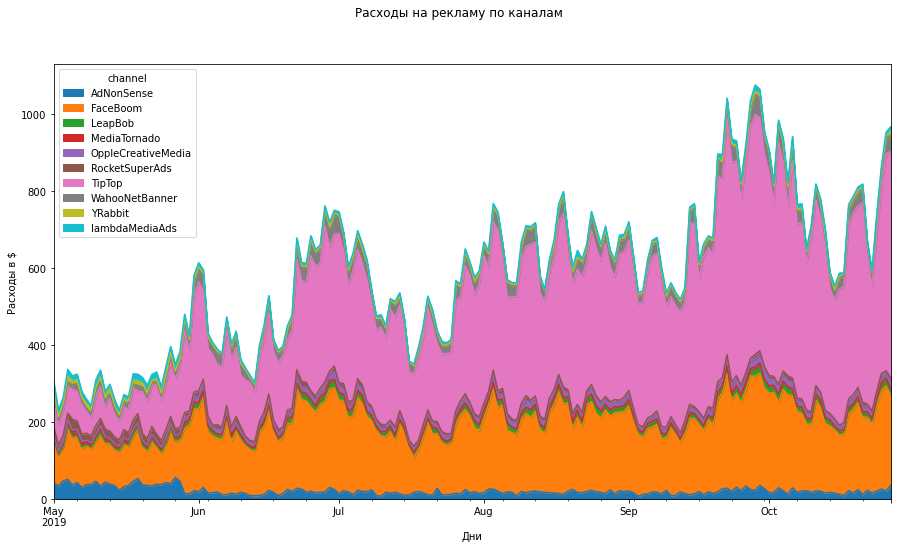

In [16]:
costs['day'] = costs['dt'].astype('datetime64[D]')
costs.pivot_table(index = 'day', columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(figsize=(15, 8))
plt.suptitle("Расходы на рекламу по каналам")
plt.xlabel("Дни")
plt.ylabel("Расходы в $")
plt.show()

Расходы на рекламу по каналам (по месяцам):

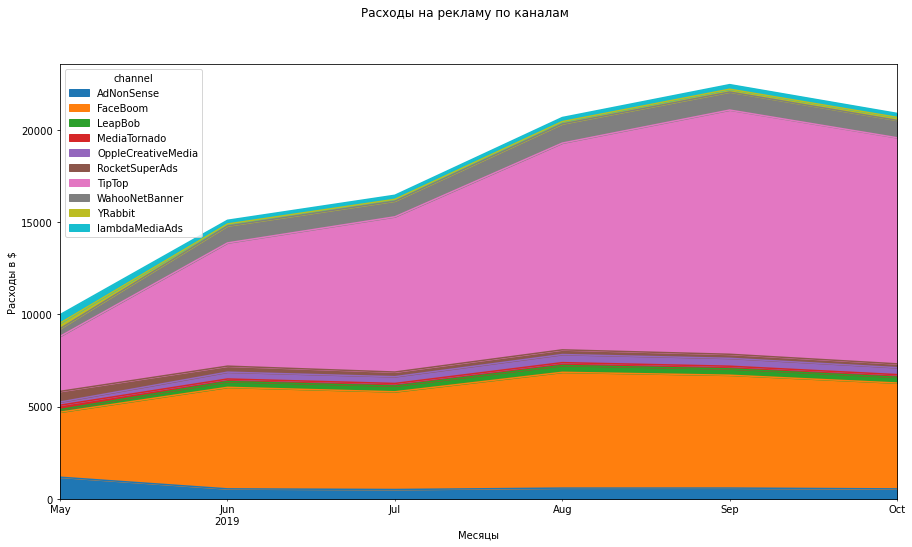

In [17]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs.pivot_table(index = 'month', columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(figsize=(15, 8))
plt.suptitle("Расходы на рекламу по каналам")
plt.xlabel("Месяцы")
plt.ylabel("Расходы в $")
plt.show()

In [18]:
print('Средняя стоимость привлечения одного покупателя из каждого источника:',
      '',
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .sort_values(by='acquisition_cost', ascending=False)
)

Средняя стоимость привлечения одного покупателя из каждого источника:                      acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000


## 5. Окупаемость рекламы для привлечения пользователей

In [19]:
# задаю момент и горизонт анализа данных
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

### Общая окупаемость рекламы

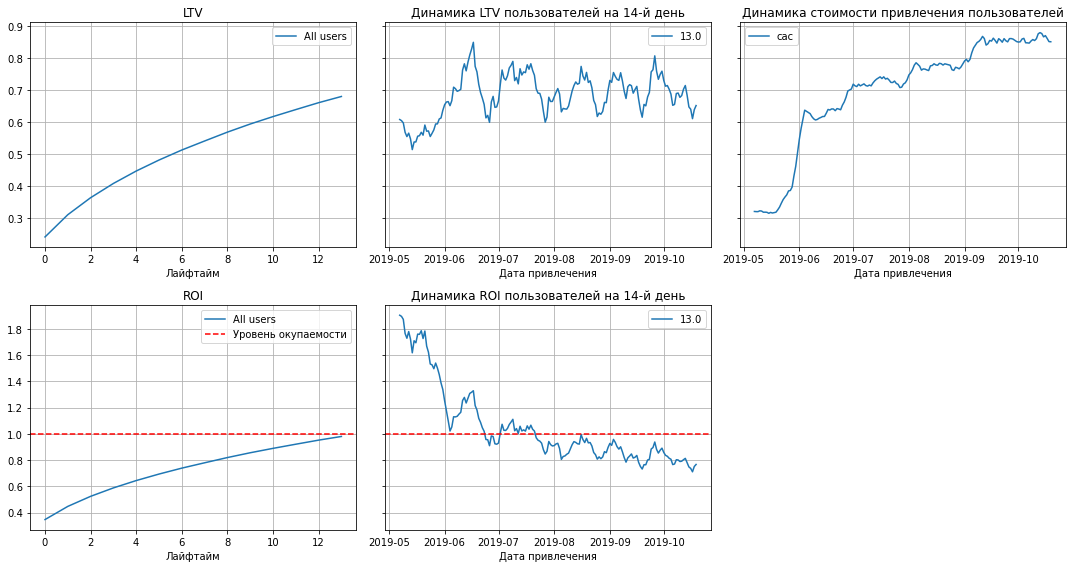

In [20]:
# считаю LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строю графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

# исключаю канал organic из расчетов
profiles = profiles.query('channel != "organic"')

Выводы по графикам:
- Реклама не окупается.
- CAC не стабилен. Значит, дело в расходах на рекламу.
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

### Окупаемость рекламы с разбивкой по устройствам

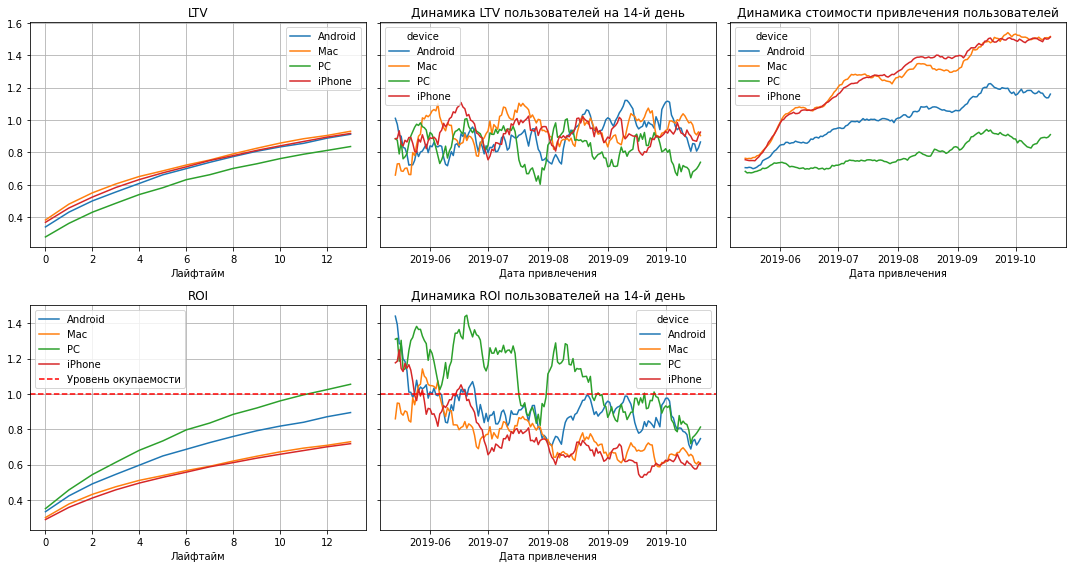

In [21]:
# окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

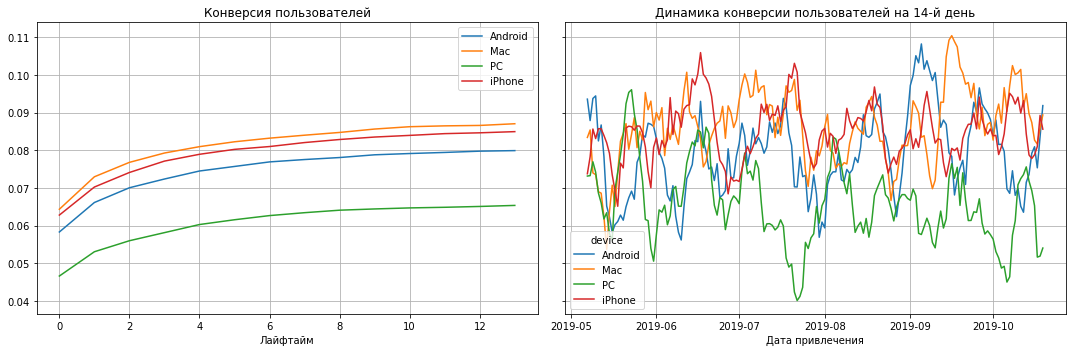

In [22]:
# конверсия с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

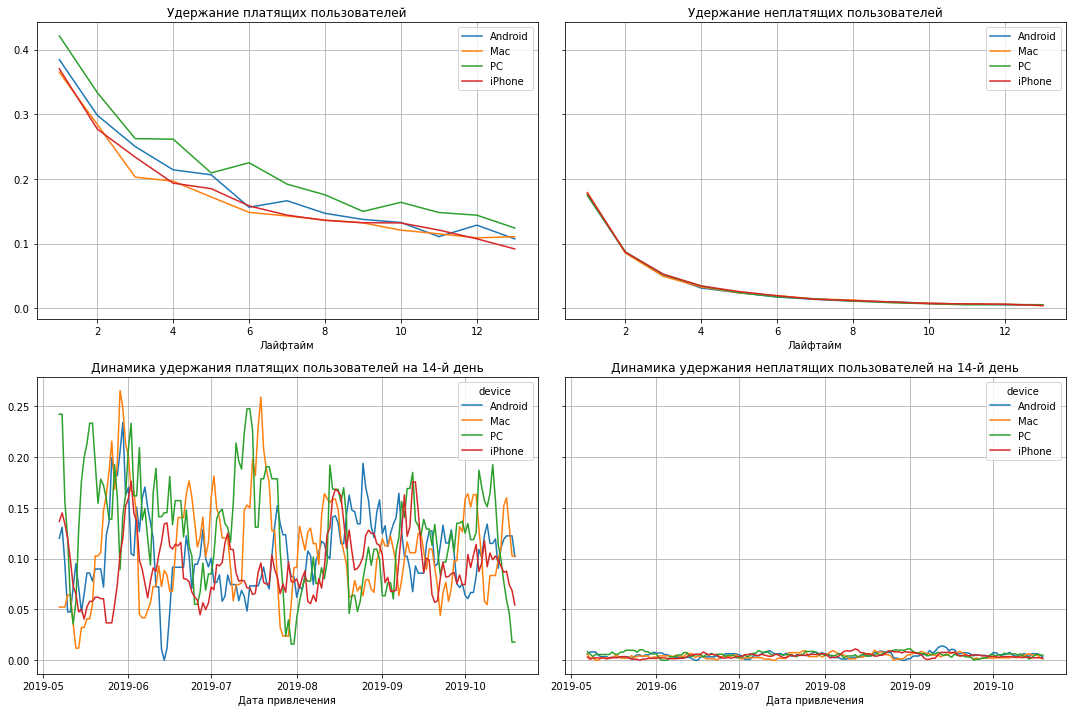

In [23]:
# удержание с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

Выводы по графикам:
- Стоимость привлечения пользователей растет.
- Реклама окупается только на PC.

### Окупаемость рекламы с разбивкой по странам

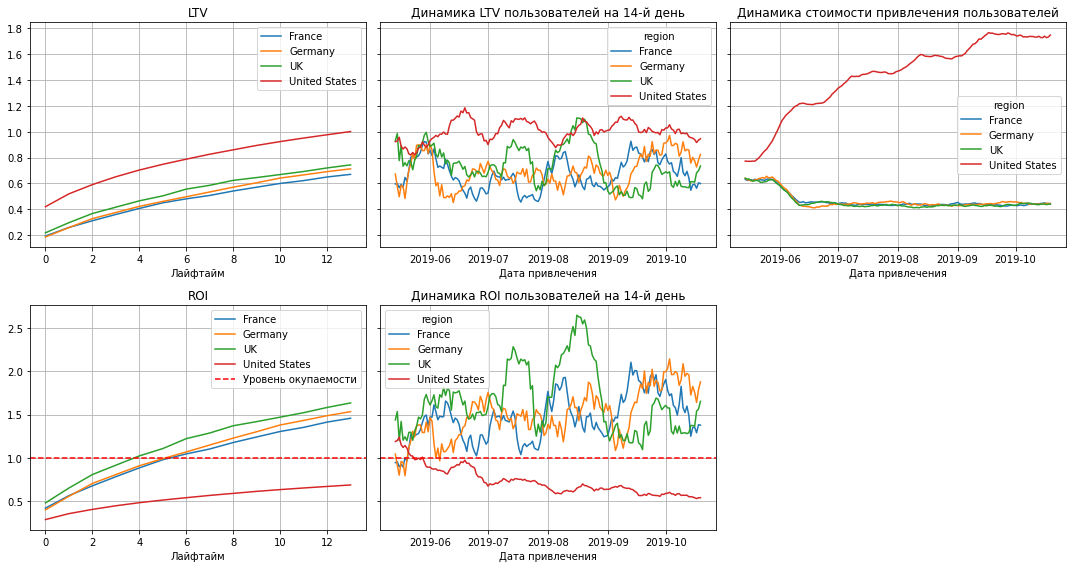

In [24]:
# окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

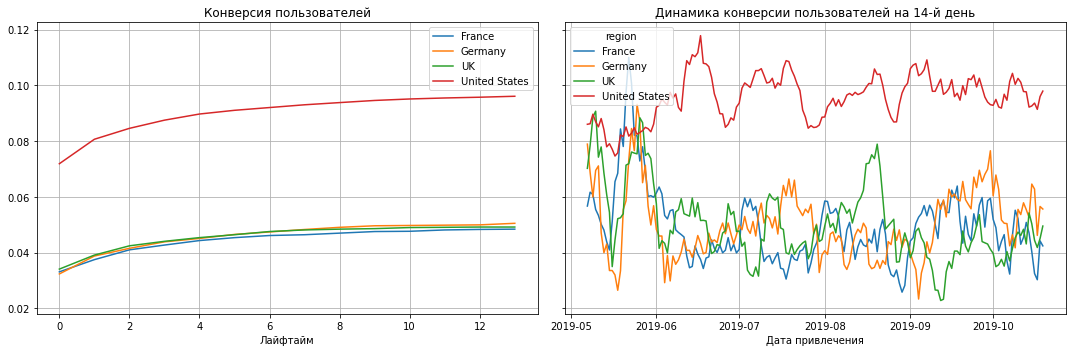

In [25]:
# конверсия с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

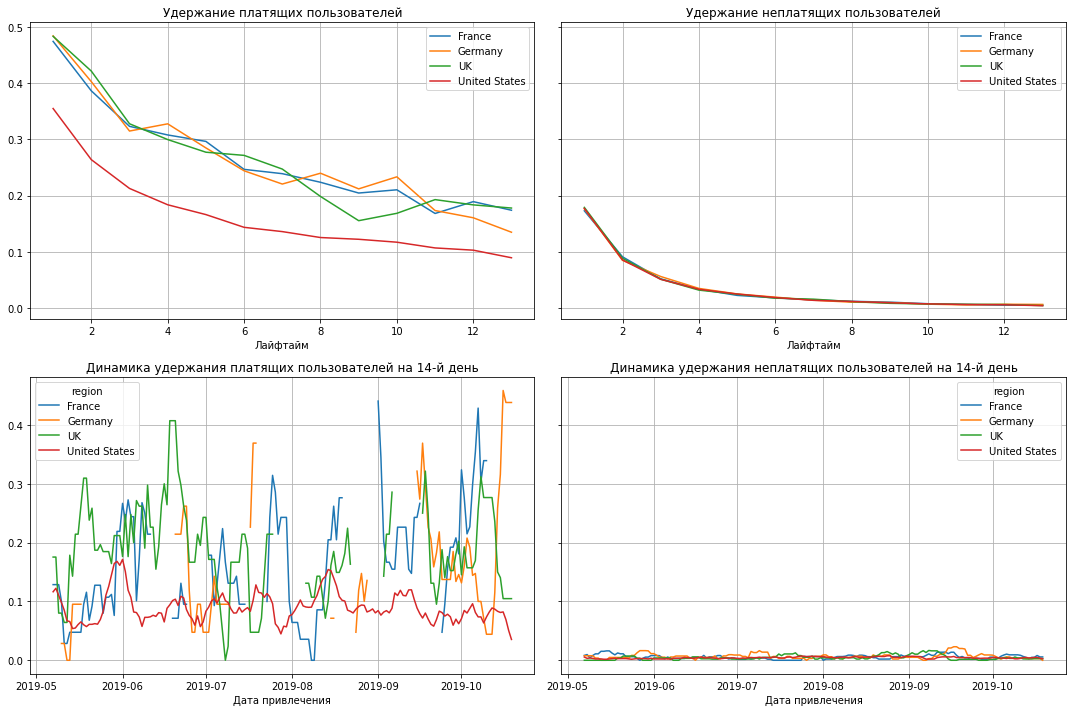

In [26]:
# удержание с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Выводы по графикам:
- Стоимость привлечения пользователей растет в США.
- Реклама в США не окупается.
- Конверсия пользователей высокая, но при этом низкое удержание платящих пользователей

### Окупаемость рекламы с разбивкой по рекламным каналам

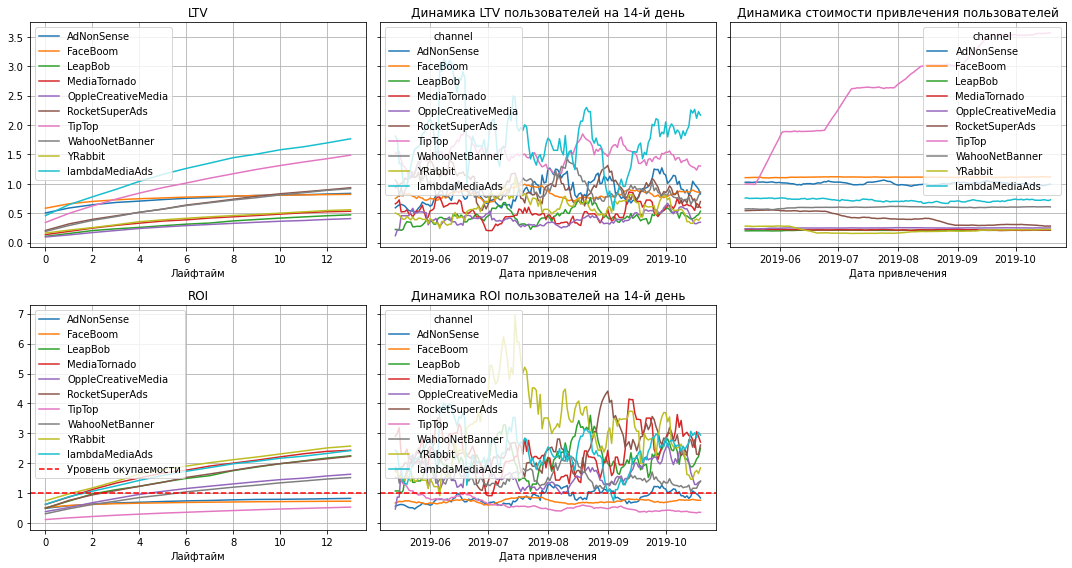

In [27]:
# окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

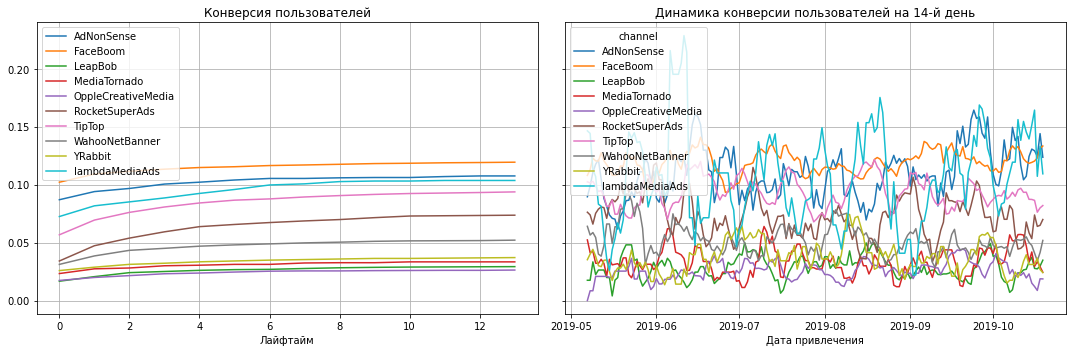

In [28]:
# конверсия с разбивкой по каналам

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

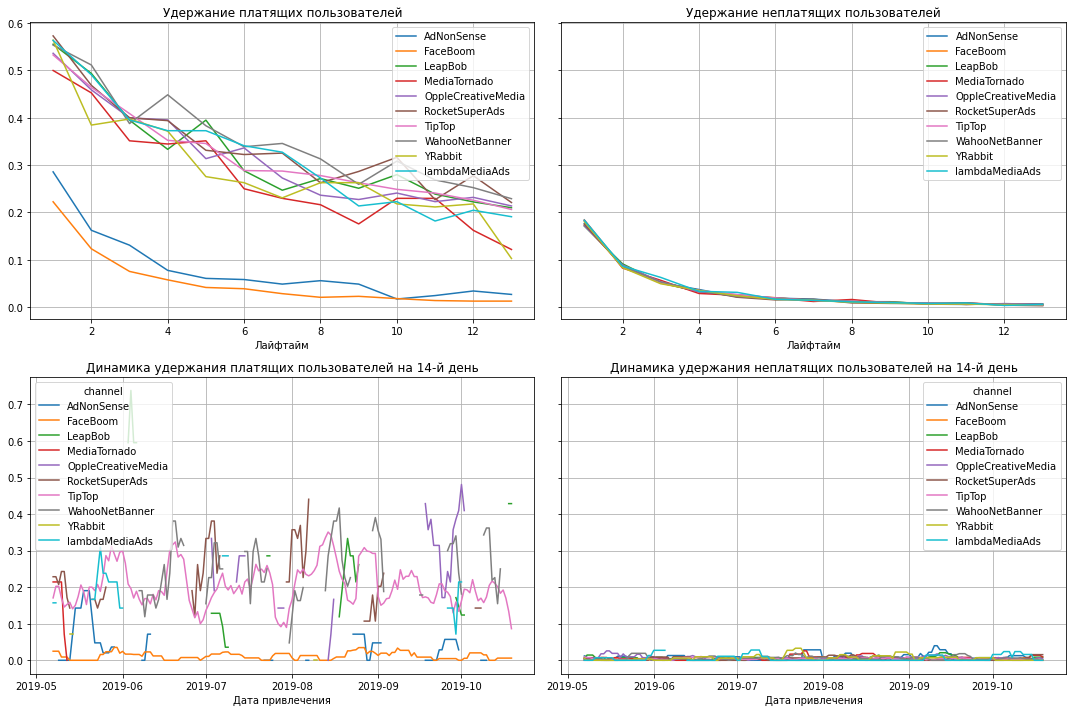

In [29]:
# удержание с разбивкой по каналам

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Выводы по графикам:
- Стоимость привлечения пользователей через TipTop растет.
- Реклама по каналам TipTop, AdNonSense, FaceBoom не окупается
- Низкое удержание платящих пользователей при высокой конверсии у каналов AdNonSense и FaceBoom

## Вывод:

    География пользователей приложения: США, Германия, Великобритания, Франция. 
    В таком же порядке убывает количество платящих пользователей.

    Устройства в порядке убывания платящих пользователей: Mac, iPhone, Android, PC

    Top-5 каналов привлечения в порядке убывания платящих пользователей: FaceBoom, AdNonSense, lambdaMediaAds, TipTop, RocketSuperAds. 
    Канал organic расположился на последней строчке.

Выводы по графикам:

    Стоимость привлечения пользователей растет.
    Реклама не окупается на iPhone и Mac.
    Стоимость привлечения пользователей растет в США.
    Реклама в США не окупается.
    Стоимость привлечения пользователей через TipTop растет.
    Реклама реклама по каналам TipTop, AdNonSense, FaceBoom не окупается

## Рекомендации:
- Отказаться от рекламы по каналам TipTop, AdNonSense, FaceBoom.

In [30]:
# исключаю каналы TipTop, AdNonSense, FaceBoom.
profiles = profiles.query("channel not in ['TipTop', 'AdNonSense', 'FaceBoom']")

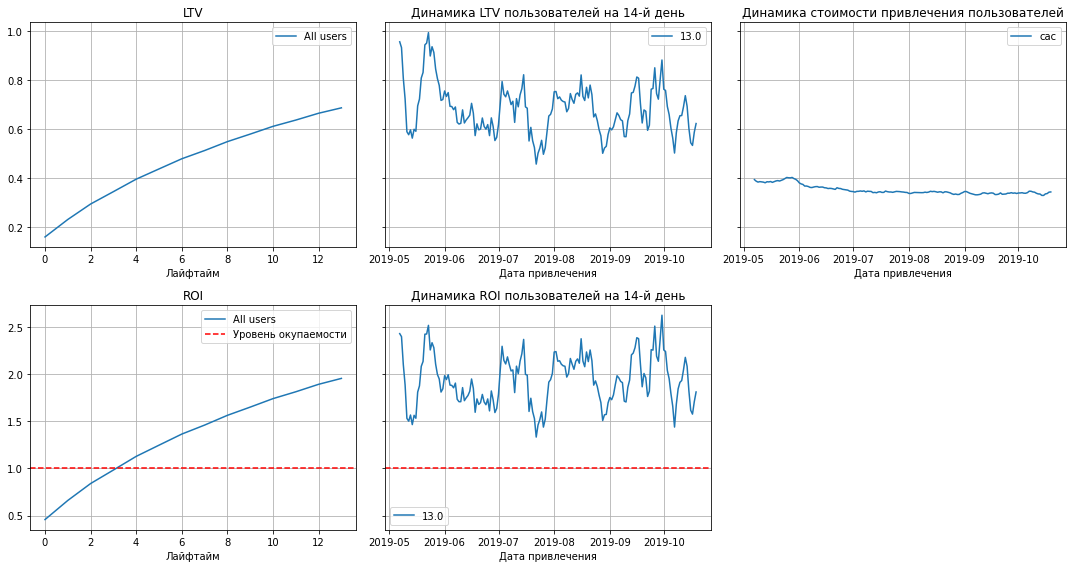

In [31]:
# смотрю общую окупаемость 

# считаю LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строю графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

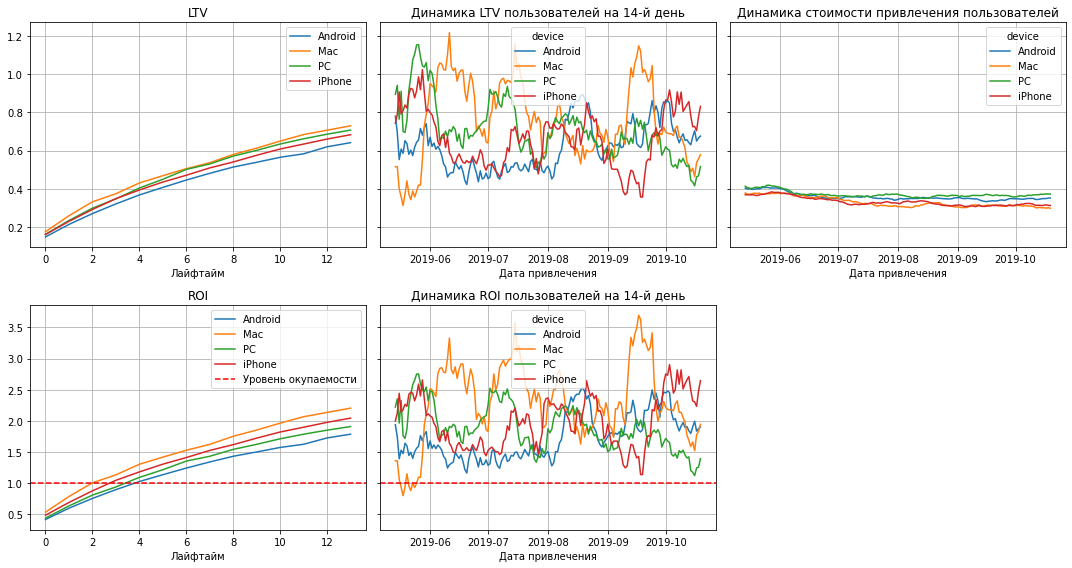

In [32]:
# смотрю окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

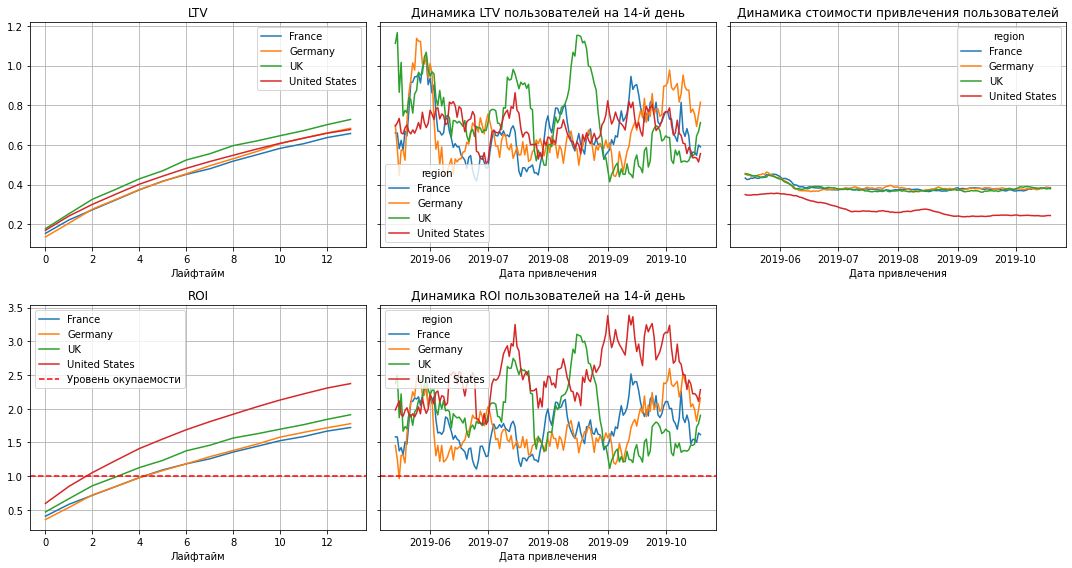

In [33]:
# окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

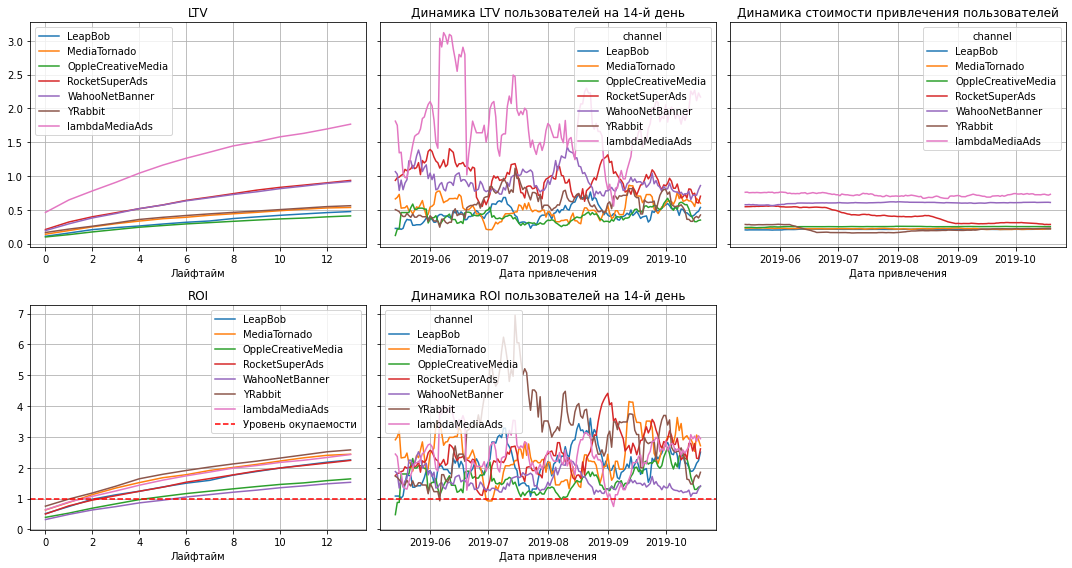

In [34]:
# окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

## Вывод: 

    После исключения каналов TipTop, AdNonSense, FaceBoom реклама окупается, CAC стабилен.